In [1]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math

import datautils

%load_ext autoreload
%autoreload 2

In [2]:
num_classes = 11
feature_dim = 62
ivector_dim = 800

In [3]:
print "Loading GloVe"
glove_dict = datautils.load_glove_dict()
print "Loading training data"
X_train, lens_train = datautils.load_train_examples(glove_dict)
ivectors_train = datautils.load_train_ivectors()
y_train = datautils.load_train_labels()
print "Loading dev data"
X_val, lens_val = datautils.load_dev_examples(glove_dict)
y_val = datautils.load_dev_labels()
ivectors_val = datautils.load_dev_ivectors()

Loading GloVe
Loading training data
Loading dev data


In [7]:
# Center and normalize the ivectors
ivectors_train -= np.mean(ivectors_train, axis=0)
ivectors_train /= np.std(ivectors_train, axis=0)

ivectors_val -= np.mean(ivectors_val, axis=0)
ivectors_val /= np.std(ivectors_val, axis=0)

print np.mean(ivectors_train), np.std(ivectors_train)
print np.mean(ivectors_val), np.std(ivectors_val)

-9.4197e-10 1.0
5.63535e-10 1.0


In [8]:
print "X_train:", X_train.shape
print "ivectors_train:", ivectors_train.shape
print "lens_train:", lens_train.shape
print "y_train:", y_train.shape

print "X_val:", X_val.shape
print "ivectors_val:", ivectors_val.shape
print "lens_val:", lens_val.shape
print "y_val:", y_val.shape

X_train: (11000, 212, 62)
ivectors_train: (11000, 800)
lens_train: (11000,)
y_train: (11000,)
X_val: (1100, 211, 62)
ivectors_val: (1100, 800)
lens_val: (1100,)
y_val: (1100,)


In [8]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, None, feature_dim])
y = tf.placeholder(tf.int64, [None])
ivectors = tf.placeholder(tf.float32, [None, ivector_dim])
lens = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

cell = tf.contrib.rnn.GRUCell(128)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32, sequence_length=lens) # Outputs: N x L x W
# TODO: figure out why some transcriptions have length 0
h1 = tf.concat((states, ivectors), axis=1)
d1 = tf.layers.dropout(h1, rate=0.3, training=is_training)
fc1 = tf.layers.dense(d1, 256, activation=tf.nn.relu)
d2 = tf.layers.dropout(fc1, rate=0.3, training=is_training)
y_out = tf.layers.dense(d2, num_classes)

mean_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y, num_classes), logits=y_out))
optimizer = tf.train.AdamOptimizer(1e-2)

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

In [9]:
def run_model(session, predict, loss_val, Xd, yd, lensd, ivectorsd
              epochs=1, batch=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch))):
            # generate indicies for the batch
            start_idx = (i*batch)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch]
            
            # get batch size
            actual_batch_size = yd[i:i+batch].shape[0]

            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx],
                         y: yd[idx],
                         lens: lensd[idx],
                         ivectors: ivectorsd[idx],
                         is_training: training_now
                         }
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

In [11]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
train_losses = []
train_acc = []
val_losses = []
val_acc = []

In [ ]:
saver = tf.train.Saver()
saver.restore(sess, "gru-model-11")
with open("gru-model.txt") as logs:
    train_losses = [ float(val) for val in logs.readline().split() ]
    val_losses = [ float(val) for val in logs.readline().split() ]
    train_acc = [ float(val) for val in logs.readline().split() ]
    val_acc = [ float(val) for val in logs.readline().split() ]

Iteration 0: with minibatch training loss = 1.05 and accuracy of 0.62
Iteration 25: with minibatch training loss = 1.05 and accuracy of 0.63
Iteration 50: with minibatch training loss = 1.2 and accuracy of 0.59
Iteration 75: with minibatch training loss = 1.2 and accuracy of 0.63
Epoch 1, Overall loss = 1.09 and accuracy of 0.623


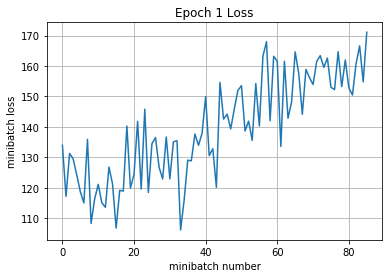

Epoch 1, Overall loss = 1.99 and accuracy of 0.375


In [22]:
epochs = 1
optimizer.learning_rate = 1e-3
d1.rate = 0.4
for i in range(epochs):
    loss, acc = run_model(session=sess,
                          predict=y_out,
                          loss_val=mean_loss,
                          Xd=X_train,
                          yd=y_train,
                          lensd=lens_train,
                          epochs=1,
                          batch=128,
                          print_every=25,
                          training=train_step,
                          plot_losses=True)
    train_losses.append(loss)
    train_acc.append(acc)
    loss, acc = run_model(session=sess,
                          predict=y_out,
                          loss_val=mean_loss,
                          Xd=X_val,
                          yd=y_val,
                          lensd=lens_val,
                          epochs=1,
                          batch=X_val.shape[0],
                          print_every=1,
                          training=None,
                          plot_losses=False)
    val_losses.append(loss)
    val_acc.append(acc)
    saver = tf.train.Saver()
    saver.save(sess, 'gru-model', global_step=len(val_acc))

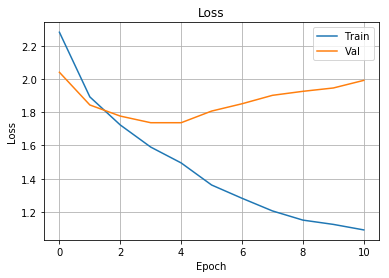

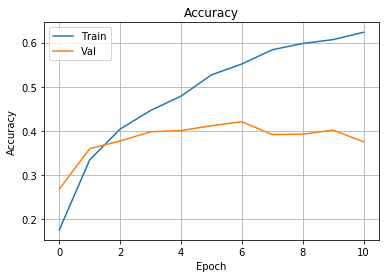

In [23]:
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.grid(True)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_acc, label='Train')
plt.plot(val_acc, label='Val')
plt.grid(True)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [24]:
f = open("gru-model.txt", 'w')
f.write(" ".join([str(num) for num in train_losses]) + "\n")
f.write(" ".join([str(num) for num in val_losses]) + "\n")
f.write(" ".join([str(num) for num in train_acc]) + "\n")
f.write(" ".join([str(num) for num in val_acc]) + "\n")
f.close()